In [150]:
import tensorflow as tf
import os 
import time
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
from tensorflow.keras import backend as K
from PIL import Image
import pickle


In [185]:
# dataset load
filepath = 'E:/jo/船橋市高瀬下水処理場画像処理AI_20211113/5-1系/img/20211124104257.pickle'
f = open(filepath,'rb')
[x_train_resize,x_test_resize] = pickle.load(f)
f.close
# x_train_resize = x_train_resize[:10000]


<function BufferedReader.close>

In [186]:
TRAIN_BUF = 17000
BATCH_SIZE = 50
TEST_BUF = 500

In [188]:
train_images = x_train_resize.reshape(x_train_resize.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_images = x_test_resize.reshape(x_test_resize.shape[0], 64, 64, 3).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# train_images = x_train_resize.reshape(x_train_resize.shape[0], 128, 128, 1).astype('float32')
# test_images = x_test_resize.reshape(x_test_resize.shape[0], 128, 128, 1).astype('float32')

# ランダム
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)


In [205]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # assert model.output_shape == (None, 128, 128, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)

    return model

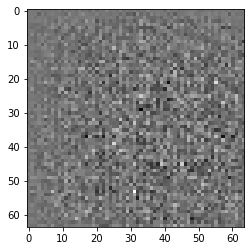

In [206]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [207]:
generator = make_generator_model()
generator.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_200 (Bat (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_304 (LeakyReLU)  (None, 16384)             0         
_________________________________________________________________
reshape_39 (Reshape)         (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_214 (Conv2D (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_201 (Bat (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_305 (LeakyReLU)  (None, 8, 8, 512)       

In [208]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [209]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_308 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_309 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 8, 8, 256)       

In [210]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00023905]], shape=(1, 1), dtype=float32)


In [211]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [212]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [213]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [214]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [215]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [216]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [217]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [218]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [219]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0] * 256, cmap='gray')
      plt.axis('off')

  plt.savefig('./graf/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

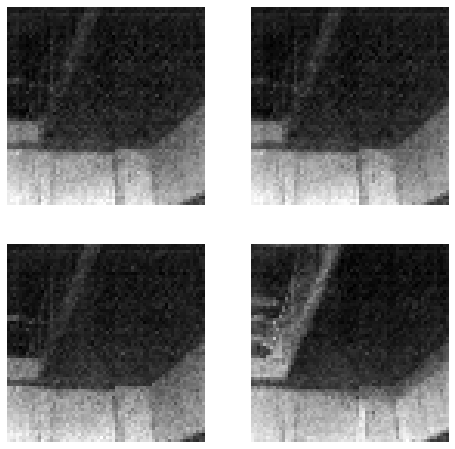

In [220]:
train(train_dataset, EPOCHS)

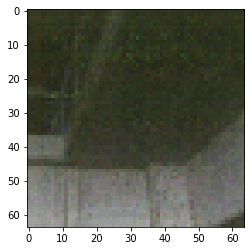

In [309]:
import cv2
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = generated_image[0, :, :, :]* 127.5 + 127.5
generated_image = np.asarray(generated_image,dtype=np.uint8)
img = Image.fromarray(generated_image)
plt.imshow(img)

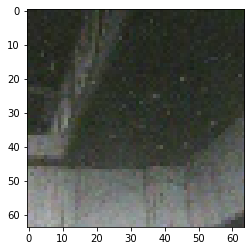

In [297]:
test_image = test_images[10]
test_image = test_image* 127.5 + 127.5
test_image = np.asarray(test_image,dtype=np.uint8)
test_img = Image.fromarray(test_image)
plt.imshow(test_img)

In [319]:
ac_img = Image.open('1.png')
image = np.asarray(ac_img,dtype=np.float32)
image = cv2.resize(image,(64,64))
image = tf.reshape(image,[1,64,64,3])
image = (image - 127.5) / 127.5 



In [335]:
fake_output =discriminator(image)

In [336]:
test_image = test_images[27]
test_image = tf.reshape(test_image,[1,64,64,3])
real_output = discriminator(test_image)

In [338]:
fake_output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.620645]], dtype=float32)>

In [339]:
real_output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.18586583]], dtype=float32)>

In [347]:
a =os.listdir('fake_image')
judgment = []
for i in a:
    path = os.path.join('fake_image',i)
    ac_img = Image.open(path)
    image = np.asarray(ac_img,dtype=np.float32)
    image = cv2.resize(image,(64,64))
    image = tf.reshape(image,[1,64,64,3])
    image = (image - 127.5) / 127.5 
    fake_output =discriminator(image)
    judgment.append(fake_output)

In [348]:
judgment

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.2834578]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.30926776]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00634889]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.0917969]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.8013813]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2337998]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.040846]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.42664003]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02270231]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.41328502]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3350781]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, num

'fake_image\\a'